In [4]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  %cd /content/drive/MyDrive/M5_Project/Week4
  !ls

In [1]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim

from PIL import Image
import pandas as pd
import numpy as np
from torch.utils.data.dataset import Dataset  # For custom datasets

from trainer import fit
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Prepare Dataset

In [2]:
TRAIN_DATA_PATH = "../MIT_split/train/"
TEST_DATA_PATH = "../MIT_split/test/"

batch_size = 128

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 8

In [3]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 256, 256])
Shape of y: torch.Size([128]) torch.int64


# Baseline

## Basic EmbeddingNet

In [3]:
# Set up the network and training parameters
from networks import BaselineNet, ClassificationNet_v2
from metrics import AccumulatedAccuracyMetric

embedding_net = BaselineNet()
model = ClassificationNet_v2(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
    print('Cuda!!!')
loss_fn = torch.nn.NLLLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.96)
n_epochs = 25
log_interval = 100

Cuda!!!


In [4]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/home/group05/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1881 (0%)]	Loss: 2.107314	Accuracy: 10.15625
Epoch: 1/25. Train set: Average loss: 3.1204	Accuracy: 14.726209463051568
Epoch: 1/25. Validation set: Average loss: 1.9505	Accuracy: 22.18091697645601
Train: [0/1881 (0%)]	Loss: 1.946557	Accuracy: 21.09375
Epoch: 2/25. Train set: Average loss: 1.8637	Accuracy: 25.996810207336523
Epoch: 2/25. Validation set: Average loss: 1.7761	Accuracy: 30.483271375464685
Train: [0/1881 (0%)]	Loss: 1.815986	Accuracy: 28.125
Epoch: 3/25. Train set: Average loss: 1.7187	Accuracy: 30.303030303030305
Epoch: 3/25. Validation set: Average loss: 1.7932	Accuracy: 27.757125154894673
Train: [0/1881 (0%)]	Loss: 1.711209	Accuracy: 33.59375
Epoch: 4/25. Train set: Average loss: 1.5516	Accuracy: 35.83200425305689
Epoch: 4/25. Validation set: Average loss: 1.6014	Accuracy: 37.42255266418835
Train: [0/1881 (0%)]	Loss: 1.450866	Accuracy: 42.96875
Epoch: 5/25. Train set: Average loss: 1.3954	Accuracy: 45.6140350877193
Epoch: 5/25. Validation set: Average loss: 1.5

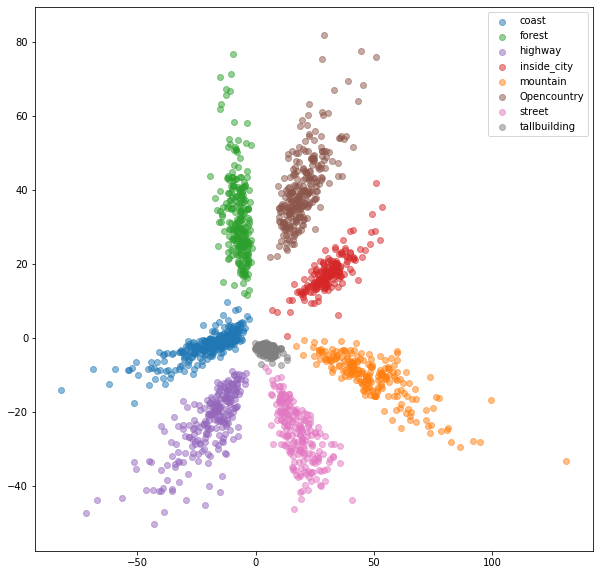

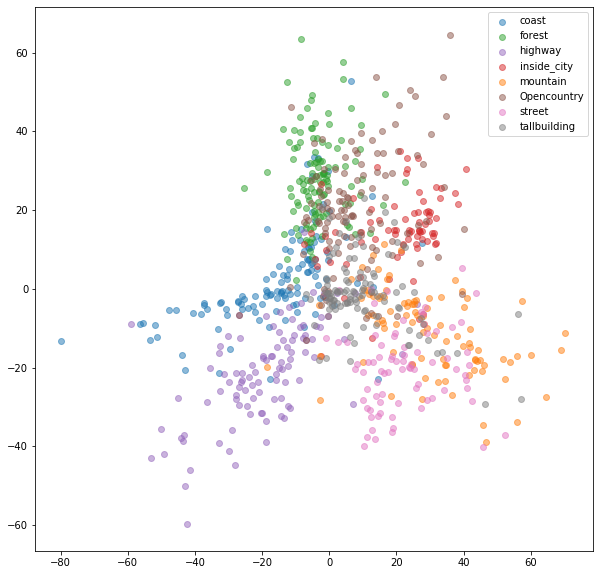

In [6]:
from embeddings_utils import *
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, 2)
plot_embeddings(train_embeddings_cl, train_labels_cl, mit_classes, colors)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model, 2)
plot_embeddings(val_embeddings_cl, val_labels_cl, mit_classes, colors)

# SiameseNet

## Set up

In [3]:
from MITSplitDataSet import MITSplitDataset_v2
cuda = torch.cuda.is_available()

TRAIN_DATA_PATH = "../MIT_split/train_data.csv"
TEST_DATA_PATH = "../MIT_split/test_data.csv"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

TRANSFORM_IMG_TEST = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

In [4]:
# Load dataset
from datasets import SiameseMNIST

# Setup datasets for training
train_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

siamese_train_dataset = SiameseMNIST(train_data) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_data)

batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

printing train data length MIT Split
1881


## Training !

In [5]:
# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()

# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.9, last_epoch=-1)
n_epochs = 30
log_interval = 1000

In [7]:
## Visualise input
a = None
for X, y in siamese_train_loader:
    a = X
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64


In [6]:
## Training !!!
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/group05/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1881 (0%)]	Loss: 0.253386
Epoch: 1/30. Train set: Average loss: 2.7215
Epoch: 1/30. Validation set: Average loss: 0.1952
Train: [0/1881 (0%)]	Loss: 0.211160
Epoch: 2/30. Train set: Average loss: 0.1705
Epoch: 2/30. Validation set: Average loss: 0.1365
Train: [0/1881 (0%)]	Loss: 0.158145
Epoch: 3/30. Train set: Average loss: 0.1435
Epoch: 3/30. Validation set: Average loss: 0.1308
Train: [0/1881 (0%)]	Loss: 0.132746
Epoch: 4/30. Train set: Average loss: 0.1369
Epoch: 4/30. Validation set: Average loss: 0.1508
Train: [0/1881 (0%)]	Loss: 0.121312
Epoch: 5/30. Train set: Average loss: 0.1223
Epoch: 5/30. Validation set: Average loss: 0.1231
Train: [0/1881 (0%)]	Loss: 0.130373
Epoch: 6/30. Train set: Average loss: 0.1111
Epoch: 6/30. Validation set: Average loss: 0.1120
Train: [0/1881 (0%)]	Loss: 0.108992
Epoch: 7/30. Train set: Average loss: 0.1086
Epoch: 7/30. Validation set: Average loss: 0.1109
Train: [0/1881 (0%)]	Loss: 0.089274
Epoch: 8/30. Train set: Average loss: 0.1022
Ep

## Visualise Embedding

In [7]:
from embeddings_utils import *

# Load embedding
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, 2)
test_embeddings_cl, test_labels_cl = extract_embeddings(test_loader, model, 2)

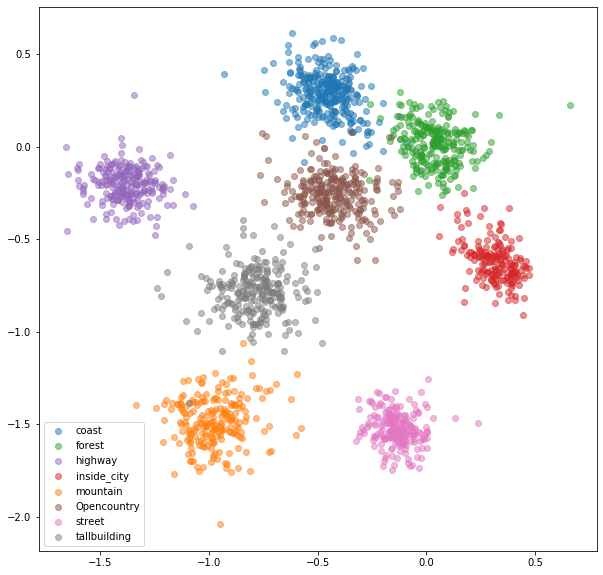

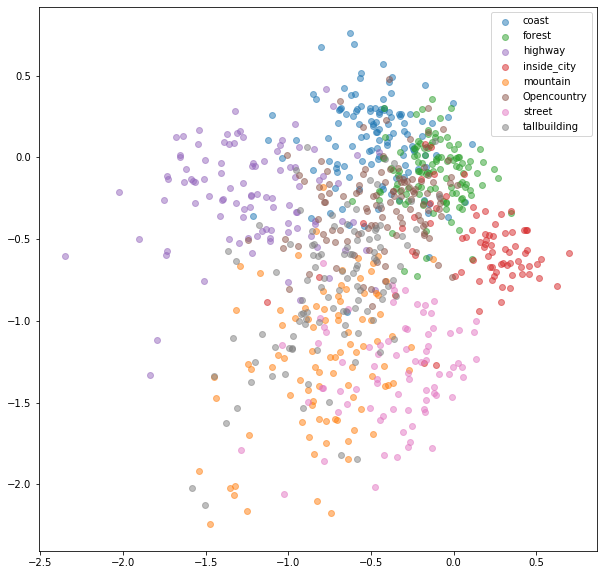

In [8]:
plot_embeddings(train_embeddings_cl, train_labels_cl, mit_classes, colors)
plot_embeddings(test_embeddings_cl, test_labels_cl, mit_classes, colors)

### PCA

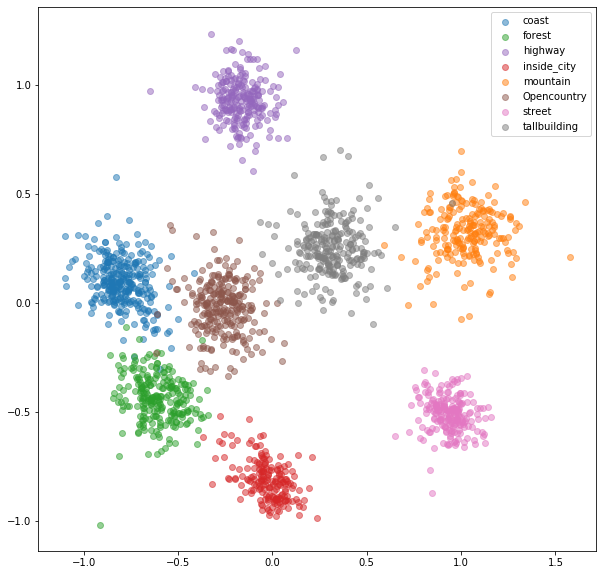

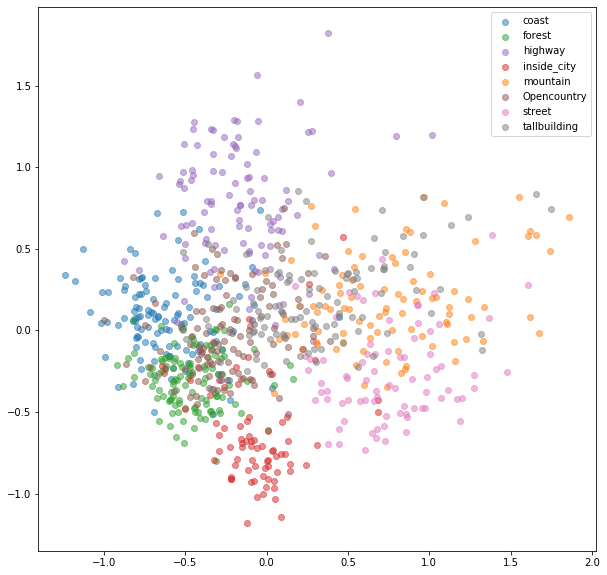

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(train_embeddings_cl)

#train embeddings
plot_embeddings(components, train_labels_cl, mit_classes, colors)

#test embedings
test_comp = pca.transform(test_embeddings_cl)
plot_embeddings(test_comp, test_labels_cl, mit_classes, colors)

### LDA

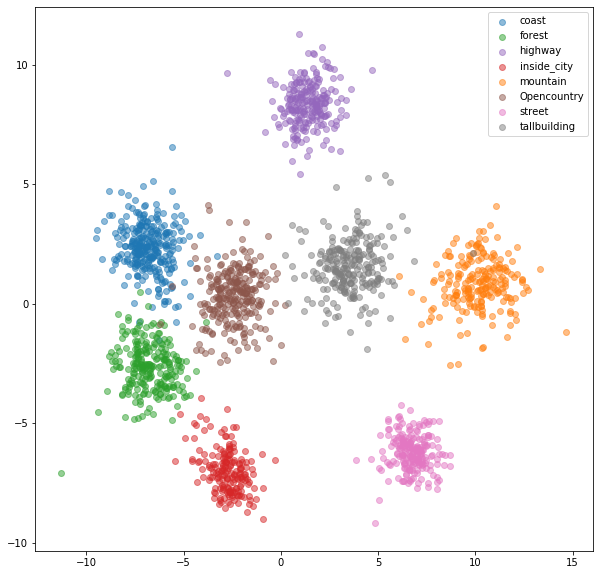

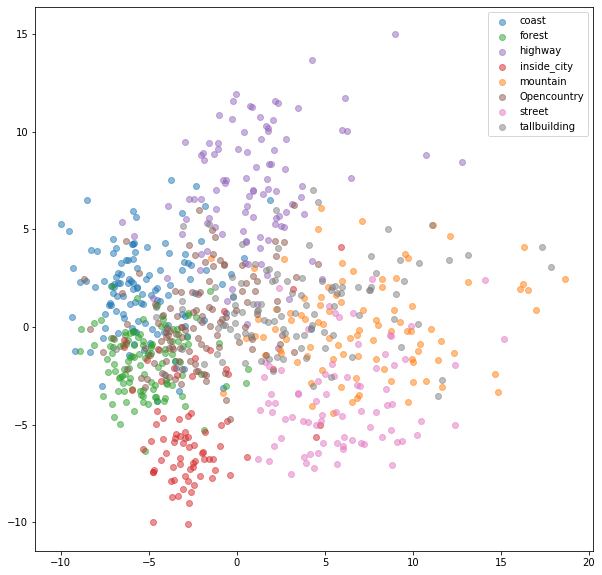

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

#train embeddings
lda_embs = lda.fit_transform(train_embeddings_cl, train_labels_cl)
plot_embeddings(lda_embs,train_labels_cl, mit_classes, colors)

#test embeddings
lda_embs_test = lda.transform(test_embeddings_cl)
plot_embeddings(lda_embs_test,test_labels_cl, mit_classes, colors)

### TSNE

/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


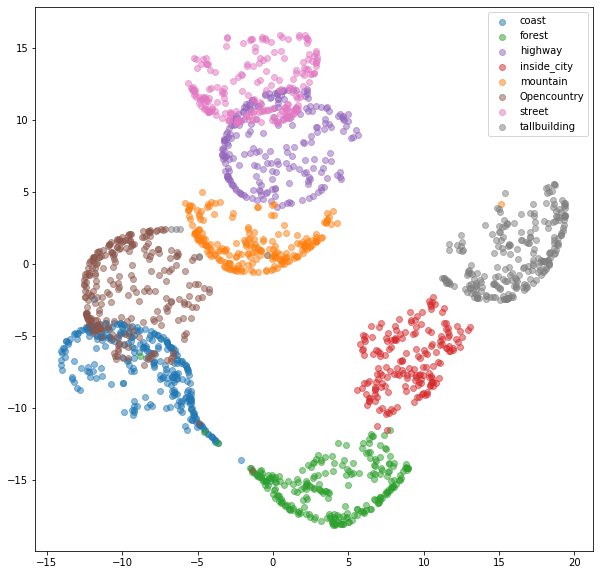

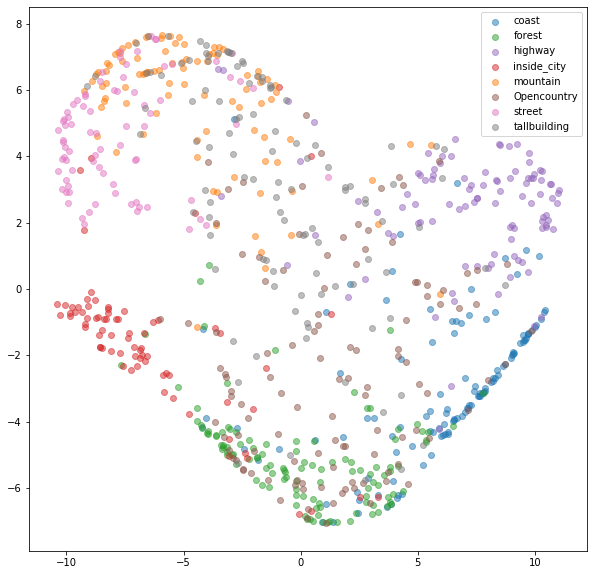

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, init='random')

embs_reduced = tsne.fit_transform(train_embeddings_cl)
plot_embeddings(embs_reduced,train_labels_cl, mit_classes, colors)

embs_reduced = tsne.fit_transform(test_embeddings_cl)
plot_embeddings(embs_reduced,test_labels_cl, mit_classes, colors)

In [12]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# TripletNet

In [13]:
from datasets import TripletMNIST

train_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

triplet_train_dataset = TripletMNIST(train_data) # Returns triplet of images and target same/different
triplet_test_dataset = TripletMNIST(test_data)

batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.96, last_epoch=-1)
n_epochs = 20
log_interval = 500

printing train data length MIT Split
1881


In [9]:
## Visualise input
for X, y in triplet_train_loader:
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: []


In [14]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/group05/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1881 (0%)]	Loss: 0.999786
Epoch: 1/20. Train set: Average loss: 5.2230
Epoch: 1/20. Validation set: Average loss: 3.5067
Train: [0/1881 (0%)]	Loss: 2.646281
Epoch: 2/20. Train set: Average loss: 1.1523
Epoch: 2/20. Validation set: Average loss: 0.9725
Train: [0/1881 (0%)]	Loss: 1.055198
Epoch: 3/20. Train set: Average loss: 0.7895
Epoch: 3/20. Validation set: Average loss: 0.7385
Train: [0/1881 (0%)]	Loss: 0.547788
Epoch: 4/20. Train set: Average loss: 0.6539
Epoch: 4/20. Validation set: Average loss: 0.6523
Train: [0/1881 (0%)]	Loss: 0.540313
Epoch: 5/20. Train set: Average loss: 0.6511
Epoch: 5/20. Validation set: Average loss: 0.6323
Train: [0/1881 (0%)]	Loss: 0.667374
Epoch: 6/20. Train set: Average loss: 0.5932
Epoch: 6/20. Validation set: Average loss: 0.6069
Train: [0/1881 (0%)]	Loss: 0.608131
Epoch: 7/20. Train set: Average loss: 0.4877
Epoch: 7/20. Validation set: Average loss: 0.6666
Train: [0/1881 (0%)]	Loss: 0.501866
Epoch: 8/20. Train set: Average loss: 0.4407
Ep

## Visualise Embedding

In [ ]:
from embeddings_utils import *

# Get embedding from train and test
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, 2)
test_embeddings_cl, test_labels_cl = extract_embeddings(test_loader, model, 2)

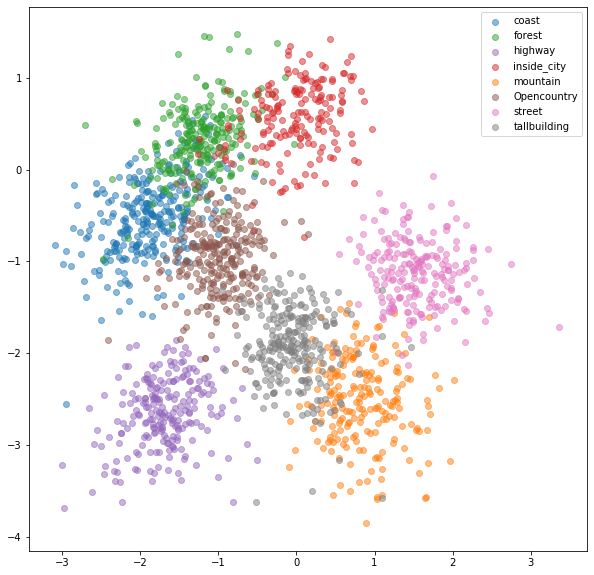

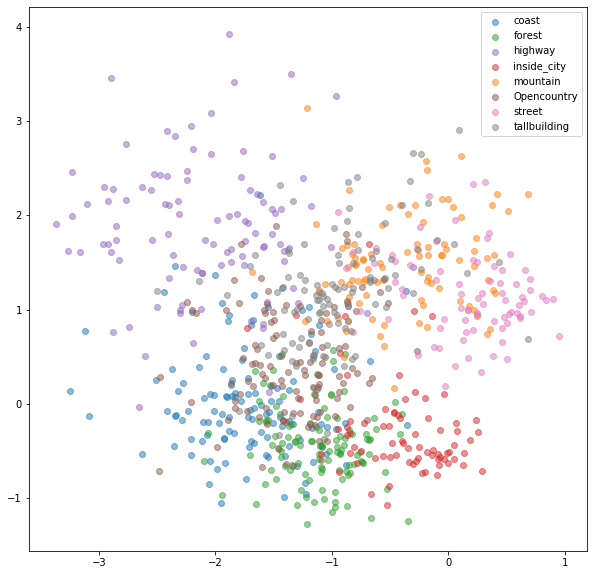

In [15]:
plot_embeddings(train_embeddings_cl, train_labels_cl, mit_classes, colors)
plot_embeddings(val_embeddings_cl, val_labels_cl, mit_classes, colors)

### PCA

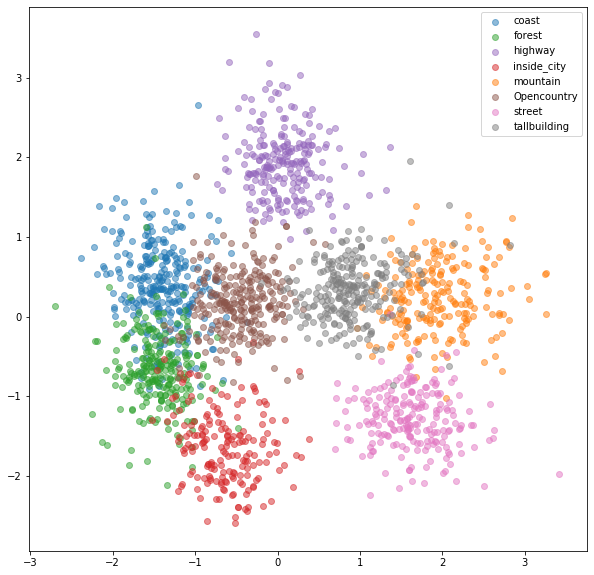

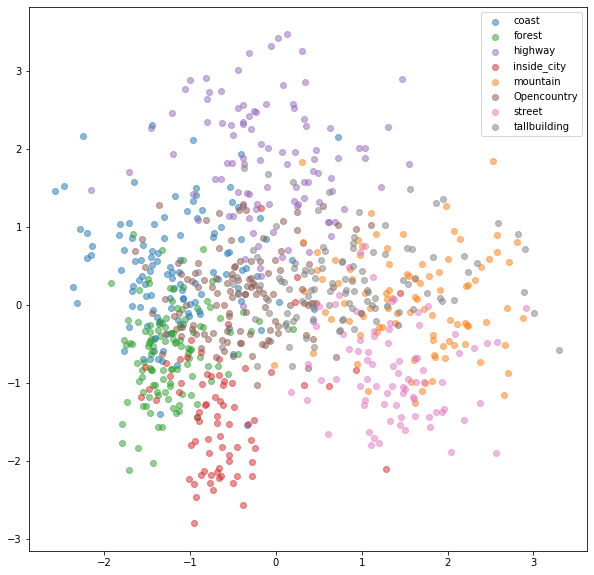

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(train_embeddings_cl)

#train embeddings
plot_embeddings(components, train_labels_cl, mit_classes, colors)

#test embedings
test_comp = pca.transform(test_embeddings_cl)
plot_embeddings(test_comp, test_labels_cl, mit_classes, colors)

### LDA

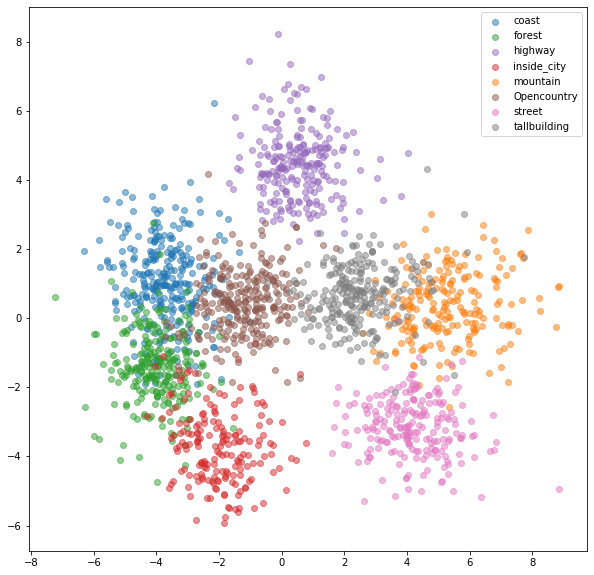

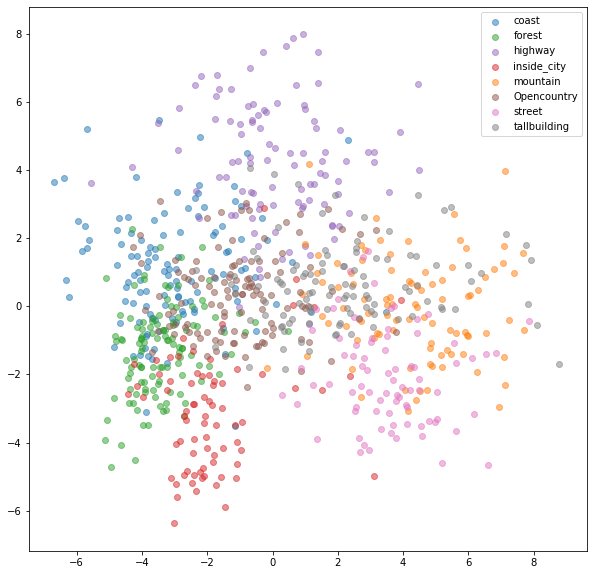

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda_embs = lda.fit_transform(train_embeddings_cl, train_labels_cl)

#train embeddings
plot_embeddings(lda_embs,train_labels_cl, mit_classes, colors)

#test embeddings
lda_embs_test = lda.transform(test_embeddings_cl)
plot_embeddings(lda_embs_test,test_labels_cl, mit_classes, colors)

### TSNE

/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


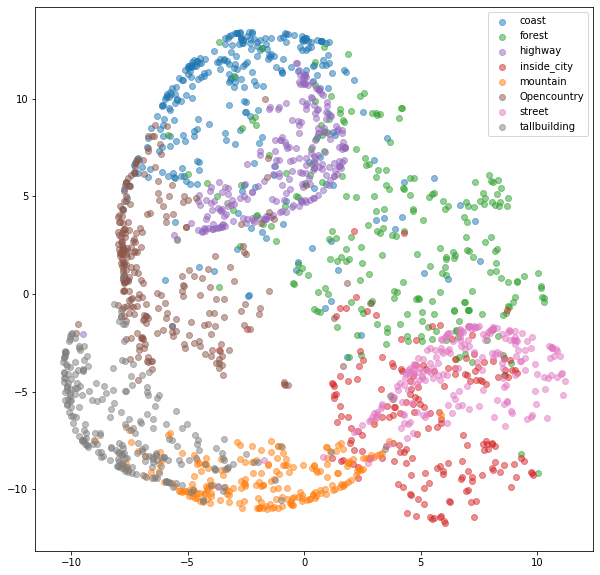

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, init='random')

embs_reduced = tsne.fit_transform(train_embeddings_cl)
plot_embeddings(embs_reduced,train_labels_cl, mit_classes, colors)

embs_reduced = tsne.fit_transform(test_embeddings_cl)
plot_embeddings(embs_reduced,test_labels_cl, mit_classes, colors)

## Balanced Batch Sampler

In [27]:
from datasets import BalancedBatchSampler

train_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_data.train_labels, n_classes=8, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_data.test_labels, n_classes=8, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_data, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_data, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 250

printing train data length MIT Split
1881


In [28]:
## Visualise input
for X, y in online_train_loader:
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

KeyError: 0

In [29]:
all_embeddings = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

KeyError: 3

In [ ]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)